# Classifier Evaluation


This notebook assumes precomputed ground truth maps as pickles. The ground truth is expected to include the following classes:

1. bacground
2. waste

and optionally

3. food

and

4. tape


In [2]:
from spectral import *
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pickle as pkl
import os
from os.path import exists
from matplotlib import cm
from sklearn.metrics import classification_report

In [3]:
dir_fn = "processed-data/sardi-capture-final/final/reflectance/2023_03_28/food_and_waste"
# dir_fn = "processed-data/sardi-capture-final/final/reflectance/2023_03_28/just_waste"

In [4]:
def process_into_rgb(loc_ds):
    """
    Processes a given dataset into an rgb image for display
    """
    loc_dc = np.array(loc_ds['datacube']).transpose(1,2,0)
    loc_binned_wavelengths = np.array(loc_ds['wavelength'])

    red_nm = 640
    green_nm = 550
    blue_nm = 470
    
    rgb = np.zeros( (*loc_dc.shape[:2],3), dtype=np.float32)
    rgb[...,0] = loc_dc[:,:,np.argmin(np.abs(loc_binned_wavelengths-red_nm))]
    rgb[...,1] = loc_dc[:,:,np.argmin(np.abs(loc_binned_wavelengths-green_nm))]
    rgb[...,2] = loc_dc[:,:,np.argmin(np.abs(loc_binned_wavelengths-blue_nm))]
    
    rgb = np.minimum(np.maximum(rgb, 0), 1)

    rgb *= 255
    rgb = rgb.astype(np.uint8)
    
    return rgb

In [5]:
# Setup required variables

class_strings = {}

class_strings[1] = "red"
class_strings[2] = "green"
class_strings[3] = "blue"
class_strings[4] = "yellow"

classes = [1,2,3,4]

empty = [0,0,0,0]

In [6]:
dir_cont = os.listdir(dir_fn)

data_cubes = [cont for cont in dir_cont if '.nc' in cont]
print(sorted(data_cubes))

['2023_03_28-02_16_51.nc', '2023_03_28-02_19_32.nc', '2023_03_28-02_21_43.nc', '2023_03_28-02_23_58.nc', '2023_03_28-02_26_42.nc', '2023_03_28-02_29_35.nc', '2023_03_28-02_33_10.nc', '2023_03_28-02_35_15.nc']


In [7]:
gnd_t_fns = []
fn_paths = []

In [8]:
for fn in data_cubes:
    fn_path = dir_fn + '/' + fn
    fn_paths.append(fn_path)
    gnd_t_fns.append(fn_path.split('.')[0] + "-gnd_t.pkl")

In [9]:
ds = nc.Dataset(fn_paths[0].replace("reflectance","radiance"))

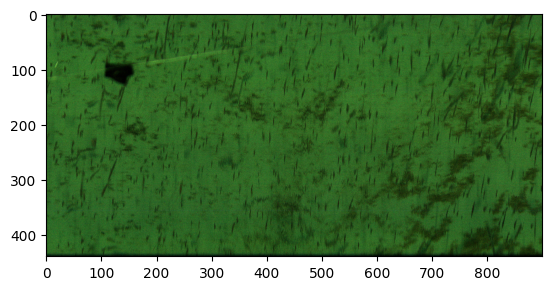

In [10]:
image = process_into_rgb(ds)
plt.imshow(image)

In [11]:
gnd_ts = []

for gnd_t_fn in gnd_t_fns:
    with open(gnd_t_fn, 'rb') as in_file:
        gnd_ts.append(pkl.load(in_file))
    

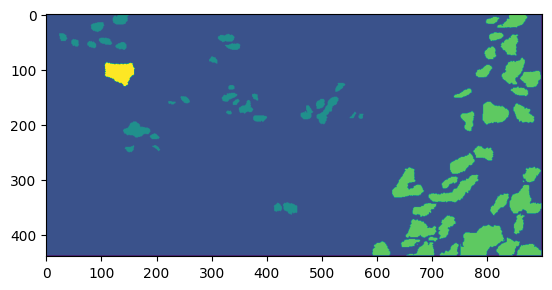

In [12]:
plt.imshow(gnd_ts[0])

Just check that the target class is correct, all gts have the same classes so once is enough.

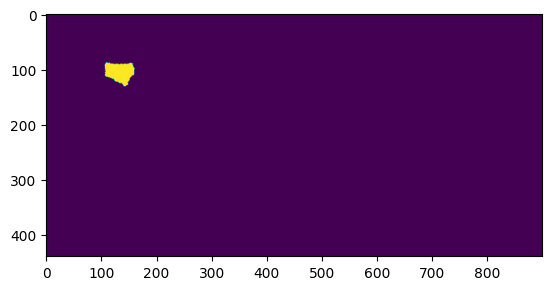

In [13]:
# must locate target in image
gnd_t_waste = gnd_ts[0].copy()

target = 4

idx = gnd_ts[0] != target
idx_target = gnd_ts[0] == target

gnd_t_waste[idx]= 0
gnd_t_waste[idx_target]= 1

plt.imshow(gnd_t_waste)

Processing file 0: processed-data/sardi-capture-final/final/reflectance/2023_03_28/food_and_waste/2023_03_28-02_33_10.nc


spectral:INFO: Setting min samples to 131


Processing...  0.0Processing... 25.0Processing... 50.0Processing... 75.0Processing... 100.Processing...done   
Processing file 1: processed-data/sardi-capture-final/final/reflectance/2023_03_28/food_and_waste/2023_03_28-02_19_32.nc


/home/solomon/.pyenv/versions/3.8.16/envs/openhsi/lib/python3.8/site-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)
spectral:INFO: Setting min samples to 131


Processing...  0.0Processing... 25.0Processing... 50.0Processing... 75.0Processing... 100.Processing...done   
Processing file 2: processed-data/sardi-capture-final/final/reflectance/2023_03_28/food_and_waste/2023_03_28-02_23_58.nc


spectral:INFO: Setting min samples to 131


Processing...  0.0Processing... 25.0Processing... 50.0Processing... 75.0Processing... 100.Processing...done   
Processing file 3: processed-data/sardi-capture-final/final/reflectance/2023_03_28/food_and_waste/2023_03_28-02_35_15.nc


spectral:INFO: Setting min samples to 131


Processing...  0.0Processing... 25.0Processing... 50.0Processing... 75.0Processing... 100.Processing...done   
Processing file 4: processed-data/sardi-capture-final/final/reflectance/2023_03_28/food_and_waste/2023_03_28-02_21_43.nc


spectral:INFO: Setting min samples to 131


Processing...  0.0Processing... 25.0Processing... 50.0Processing... 75.0Processing... 100.Processing...done   
Processing file 5: processed-data/sardi-capture-final/final/reflectance/2023_03_28/food_and_waste/2023_03_28-02_16_51.nc


spectral:INFO: Setting min samples to 131


Processing...  0.0Processing... 25.0Processing... 50.0Processing... 75.0Processing... 100.Processing...done   
Processing file 6: processed-data/sardi-capture-final/final/reflectance/2023_03_28/food_and_waste/2023_03_28-02_29_35.nc


spectral:INFO: Setting min samples to 131


Processing...  0.0Processing... 25.0Processing... 50.0Processing... 75.0Processing... 100.Processing...done   
Processing file 7: processed-data/sardi-capture-final/final/reflectance/2023_03_28/food_and_waste/2023_03_28-02_26_42.nc


spectral:INFO: Setting min samples to 131


Processing...  0.0Processing... 25.0Processing... 50.0Processing... 75.0Processing... 100.Processing...done   


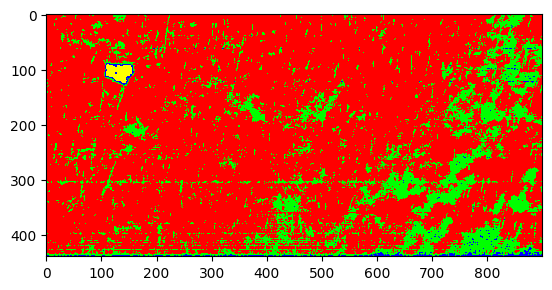

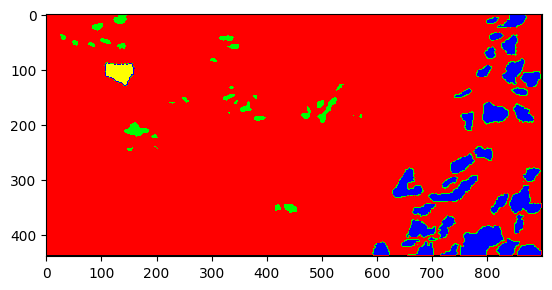

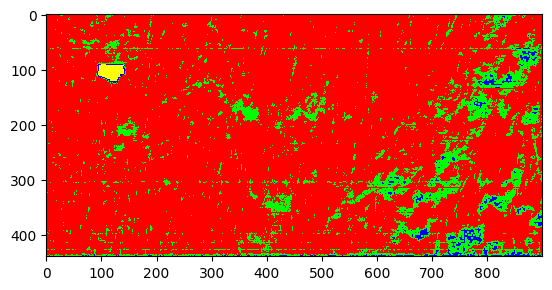

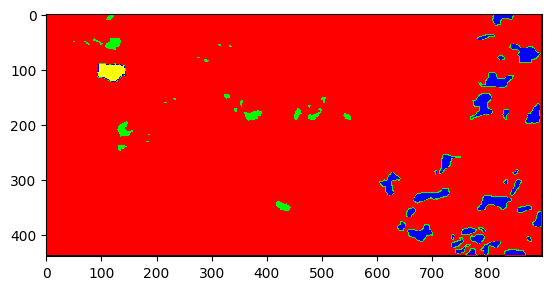

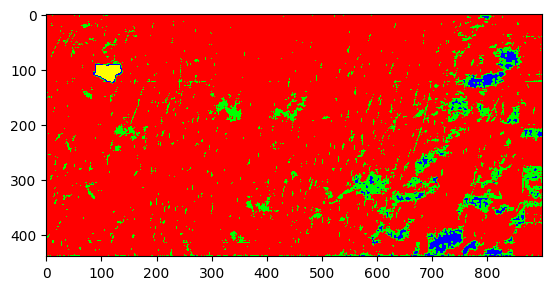

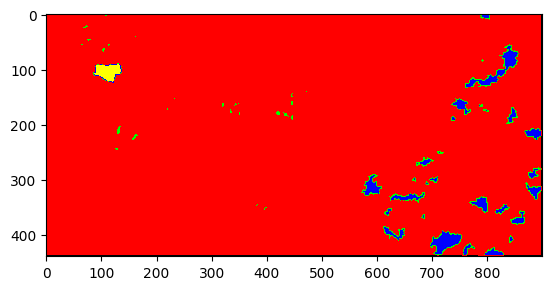

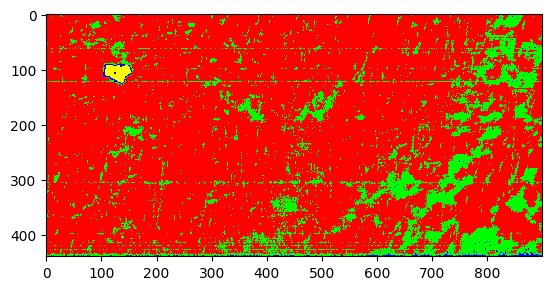

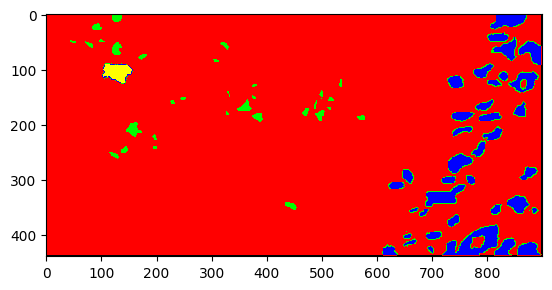

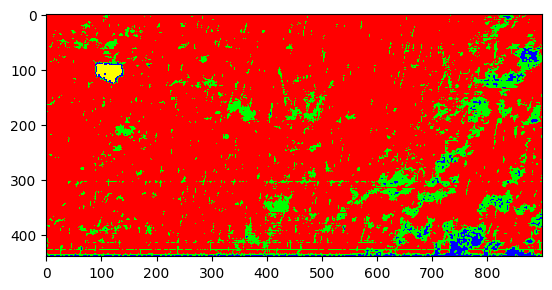

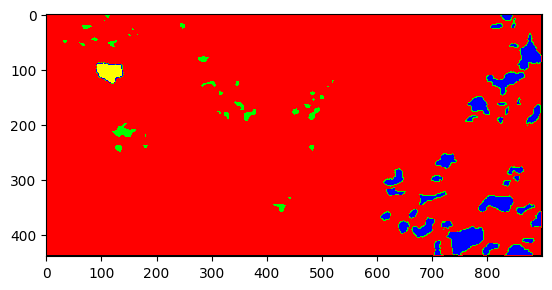

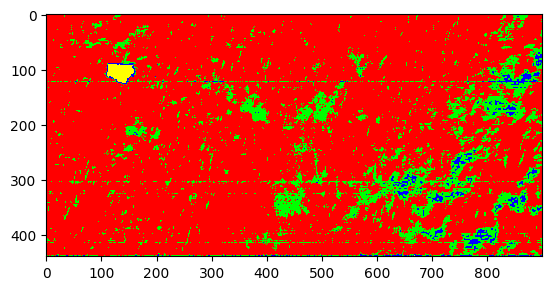

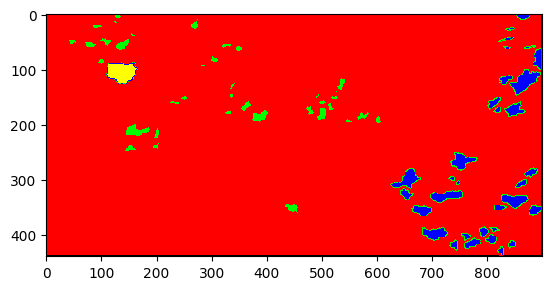

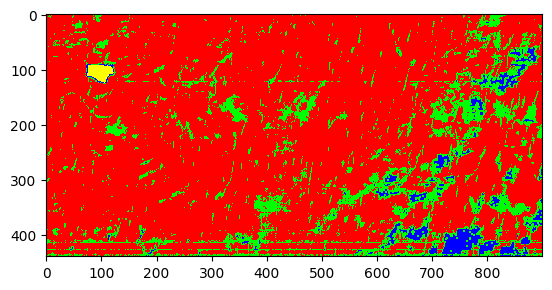

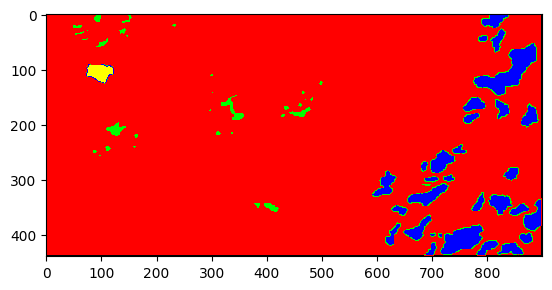

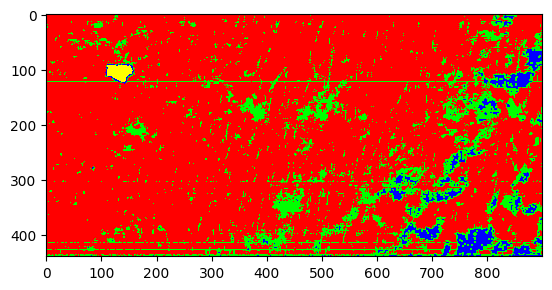

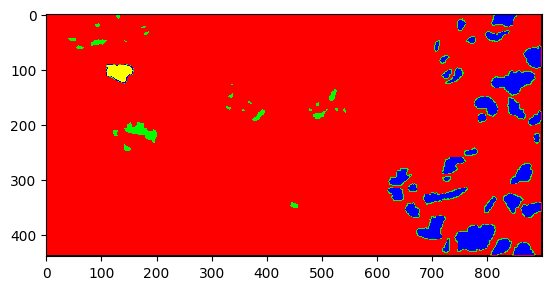

In [14]:
classifier_created = False
classifications = []
ground_truths = []

for i in range(len(fn_paths)):
    print("Processing file " + str(i) + ": " + fn_paths[i])
    
    # get files for this work
    gnd_t_fn = gnd_t_fns[i]
    
    # read the netCDF file
    ds = nc.Dataset(fn_paths[i])
    
    # extract the datacube from the dataset
    dc = np.array(ds['datacube'])
    
    # Data needs to be x, y, bands instead of bands, x, y.
    data = dc.transpose(1,2,0)
    
    # Read in ground truth
    with open(gnd_t_fn, 'rb') as in_file:
        ground_truth = pkl.load(in_file)
    
    # Create and run GMLC
    # create the classes to train the classifier
    training_classes = create_training_classes(data, ground_truth)
    
    # The classifier should only be created once, then used for all images.
    if classifier_created == False:
        classifier_created = True
        # create an instance of the classifier
    classifier = GaussianClassifier(training_classes)

    # classifier the hsi image
    classified_data = classifier.classify_image(data)
    
    # view the classified image
    v = imshow(classes=classified_data)
    classifications.append(classified_data)
    
    # view the ground truth
    v = imshow(classes=ground_truth)
    ground_truths.append(ground_truth)

In [15]:
y_true = []
y_iou = []

print("Evaluating Classifications...")

# Evaluate the classifications
for i in range(len(classifications)):
    print("Evaluating classification " + str(i) + "...")
      
    classified_data = classifications[i]
    ground_truth = ground_truths[i]
    
    # setup IoU data
    tp = empty.copy()
    fp = empty.copy()
    tn = empty.copy()
    fn = empty.copy()
    
    for i in classes:
        y_true.append(i)
        
        for x in range(classified_data.shape[0]-1):
            for y in range(classified_data.shape[1]-1):                
                # calculate classification metrics
                if ground_truth[x,y] == classified_data[x,y] == i: # true positive, both gt and classified classes match
                    tp[i-1] += 1
                elif ground_truth[x,y] == i and classified_data[x,y] != i: # false negative, gt and classified should match but classified doesn't
                    fn[i-1] += 1
                elif ground_truth[x,y] != i and classified_data[x,y] == i: # false positive, gt is not the class, but classified is
                    fp[i-1] += 1
                elif ground_truth[x,y] != i and classified_data[x,y] != i: # true negative the ground truth and the classified don't match
                    tn[i-1] += 1
                
        # Calculate IoU value for the class.
        y_iou.append(tp[i-1]/(tp[i-1]+fp[i-1]+fn[i-1]))
        

Evaluating Classifications...
Evaluating classification 0...
Evaluating classification 1...
Evaluating classification 2...
Evaluating classification 3...
Evaluating classification 4...
Evaluating classification 5...
Evaluating classification 6...
Evaluating classification 7...


In [16]:
y_pred = []

for i in range(len(classifications)):
    
    print("Evaluating classification " + str(i) + "...")
      
    classified_data = classifications[i]
    ground_truth = ground_truths[i]
    
    for j in classes:
        if y_iou[i] > 0.8:
            # this is acceptable overlap
            y_pred.append(j)
        else:
            mask = ground_truth.copy()
        
            for x in range(classified_data.shape[0]-1):
                for y in range(classified_data.shape[1]-1):
                    # create mask
                    mask[x,y] = 1 if ground_truth[x,y] == i else 0
                    
            cls_img = classified_data * mask
                    
            line = cls_img.copy().reshape(cls_img.shape[0]*cls_img.shape[1])

            occurances = np.bincount(line)

            y_pred.append(np.argmax(occurances)+1)  

Evaluating classification 0...
Evaluating classification 1...
Evaluating classification 2...
Evaluating classification 3...
Evaluating classification 4...
Evaluating classification 5...
Evaluating classification 6...
Evaluating classification 7...


### View results

note, due to the inaccurate ground truth, there are many errors in classification (technically) as the background is being *correctly* classified as what it should where it hasn't been labelled properly in the ground truth.

[useful](https://towardsdatascience.com/guide-to-confusion-matrices-classification-performance-metrics-a0ebfc08408e)

In [34]:
for i in range(len(ground_truths)):
    idx = ground_truths[i] == 0
    ground_truths[i][idx] = 1

In [35]:
print(y_true)

[1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]


In [36]:
print(y_pred)

[1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4]


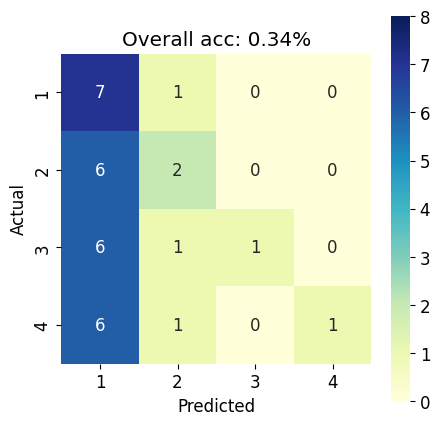

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd

class_labels = ['background', 'waste', 'food', 'tape']
class_labels = classes
 
# multilabel_confusion_matrix(y_true, y_pred, *, sample_weight=None, labels=None, samplewise=False)
cm = confusion_matrix(y_true, y_pred, labels=classes)

df_cm = pd.DataFrame(cm, columns=class_labels, index=class_labels)

fig, ax1 = plt.subplots(1,1, figsize=(5,5))
plt.rcParams['font.size'] = 12

sns.heatmap(df_cm, annot=True, ax=ax1,square=True,  cmap="YlGnBu",vmin=0,vmax=8,fmt='d')

ax1.set_title('Overall acc: {:.2f}%'.format(accuracy_score(y_true, y_pred)))
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual');

In [38]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.28      0.88      0.42         8
           2       0.40      0.25      0.31         8
           3       1.00      0.12      0.22         8
           4       1.00      0.12      0.22         8

    accuracy                           0.34        32
   macro avg       0.67      0.34      0.29        32
weighted avg       0.67      0.34      0.29        32



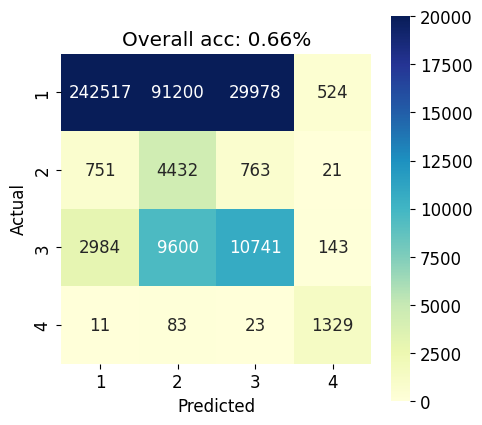

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd

class_labels = ['background', 'waste', 'food', 'tape']
class_labels = classes


new_shape = ground_truths[3].shape[0]*ground_truths[3].shape[1]
    
    
# multilabel_confusion_matrix(y_true, y_pred, *, sample_weight=None, labels=None, samplewise=False)
cm = confusion_matrix(ground_truths[3].reshape(new_shape), classifications[3].reshape(new_shape), labels=classes)

df_cm = pd.DataFrame(cm, columns=class_labels, index=class_labels)

fig, ax1 = plt.subplots(1,1, figsize=(5,5))
plt.rcParams['font.size'] = 12

sns.heatmap(df_cm, annot=True, ax=ax1,square=True,  cmap="YlGnBu",vmin=0,vmax=20000,fmt='d')

ax1.set_title('Overall acc: {:.2f}%'.format(accuracy_score(ground_truths[3].reshape(new_shape), classifications[3].reshape(new_shape))))
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual');

In [33]:
print(classification_report(ground_truths[3].reshape(new_shape), classifications[3].reshape(new_shape)))

              precision    recall  f1-score   support

           1       0.98      0.67      0.79    364219
           2       0.04      0.74      0.08      5967
           3       0.26      0.46      0.33     23468
           4       0.66      0.92      0.77      1446

    accuracy                           0.66    395100
   macro avg       0.49      0.70      0.49    395100
weighted avg       0.93      0.66      0.76    395100



In [ ]:
cv.destroyAllWindows()